# Setup and preprocessing

## Load CSV to dataframe

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [2]:
from tqdm import tqdm
from PIL import UnidentifiedImageError
import ast

In [3]:
GENRE_NAMES = ["action", "adventure", "animation", "biography", "comedy", "crime", "drama", "family", "fantasy", "film-noir", "history", "horror", "music", "musical", "mystery", "romance", "scifi", "sport", "thriller", "war", "western"]

In [4]:
path_ls = [f'../raw_data/csv_files/{genre_name}.csv' for genre_name in GENRE_NAMES]
df = pd.concat(
    map(pd.read_csv, path_ls), ignore_index=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')].drop_duplicates().reset_index(drop=True)

In [5]:
df.shape

(3425, 5)

## Image to array

In [6]:
# resize all images to 350x350
# convert images to arrays (ignore corrupted images)
width, height = 350, 350
image_array = []
unidentified_count = 0
not_found_count = 0
for i in tqdm(range(df.shape[0])):
    try:
        image_path = f"../raw_data/posters/all/{df['imdb_id'][i]}.jpg"
        img = image.load_img(image_path, target_size=(width, height, 3))
        input_arr = image.img_to_array(img)
        input_arr = input_arr/255.0
        image_array.append([df['imdb_id'][i], input_arr])
    except UnidentifiedImageError as e1:
        unidentified_count += 1
        pass
    except FileNotFoundError as e2:
        not_found_count += 1
        pass
print(f"{unidentified_count} files were unidentified and {not_found_count} files were not found")
img_array_df = pd.DataFrame(image_array, columns=["imdb_id", "image_array"])

  0%|          | 0/3425 [00:00<?, ?it/s]

100%|██████████| 3425/3425 [00:11<00:00, 297.48it/s]

162 files were unidentified and 39 files were not found


In [7]:
# join image_array_df and df on imdb_id (to delete imdb_id with corrupted images)
raw_genre_img_df = df.merge(img_array_df, on="imdb_id", how="right").drop(columns='image_url')

In [8]:
raw_genre_img_df = raw_genre_img_df.dropna().reset_index(drop=True)

## Hot encoding genres (converting to binary columns)

In [9]:
raw_genre_img_df["genre"] = (
    raw_genre_img_df["genre"]
    .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    .apply(lambda x: [genre.strip() for genre in x])
    )

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(raw_genre_img_df["genre"])

# transform target variable
y = multilabel_binarizer.transform(raw_genre_img_df["genre"])
genre_names = multilabel_binarizer.classes_

# Adding binary columns to main df
for i in range(len(genre_names)):
    raw_genre_img_df[f"{genre_names[i]}"] = y[:,i]

raw_genre_img_df.head(4)

,movie,imdb_id,genre,plot,image_array,Action,Adventure,Animation,Biography,Comedy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,Ramayana: The Legend of Prince Rama,tt0259534,"[Animation, Action, Adventure]","The fantastic story of Rama, a young prince wh...","[[[0.654902, 0.5686275, 0.40784314], [0.819607...",1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Dark Knight,tt0468569,"[Action, Crime, Drama]",Set within a year after the events of Batman B...,"[[[0.16470589, 0.3019608, 0.4509804], [0.16078...",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Lord of the Rings: The Return of the King,tt0167260,"[Action, Adventure, Drama]",The final confrontation between the forces of ...,"[[[0.54509807, 0.4117647, 0.23529412], [0.5490...",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Spider-Man: Across the Spider-Verse,tt9362722,"[Animation, Action, Adventure]",Miles Morales returns for the next chapter of ...,"[[[0.49019608, 0.10980392, 0.5137255], [0.4901...",1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prepare train and val dataset

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = raw_genre_img_df["image_array"].values
y = raw_genre_img_df.drop(['movie', 'imdb_id', 'genre', 'plot', 'image_array'],axis=1)
X = np.array(list(X))
y = y.to_numpy()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

In [13]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

# Deep learning Model

## Prepare the model

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [15]:
model = Sequential()
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))


model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(y.shape[1],activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 348, 348, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 348, 348, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 174, 174, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 174, 174, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 172, 172, 32)      1

## Compile, fit, cross validate

In [17]:
import matplotlib.pyplot as plt

In [18]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/10
84/84 [==============================] - 95s 1s/step - loss: 0.2124 - accuracy: 0.3322 - val_loss: 0.2914 - val_accuracy: 0.1879
Epoch 2/10
84/84 [==============================] - 90s 1s/step - loss: 0.1771 - accuracy: 0.3669 - val_loss: 0.2875 - val_accuracy: 0.1913
Epoch 3/10
84/84 [==============================] - 89s 1s/step - loss: 0.1519 - accuracy: 0.3896 - val_loss: 0.2790 - val_accuracy: 0.3154
Epoch 4/10
84/84 [==============================] - 90s 1s/step - loss: 0.1338 - accuracy: 0.3982 - val_loss: 0.2705 - val_accuracy: 0.2181
Epoch 5/10
67/84 [======================>.......] - ETA: 17s - loss: 0.1191 - accuracy: 0.4002

KeyboardInterrupt: 

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

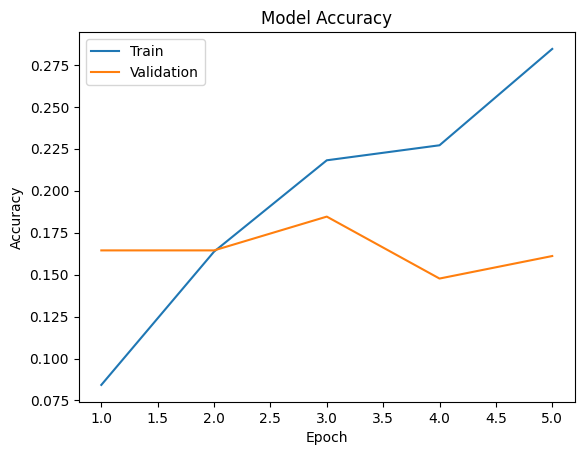

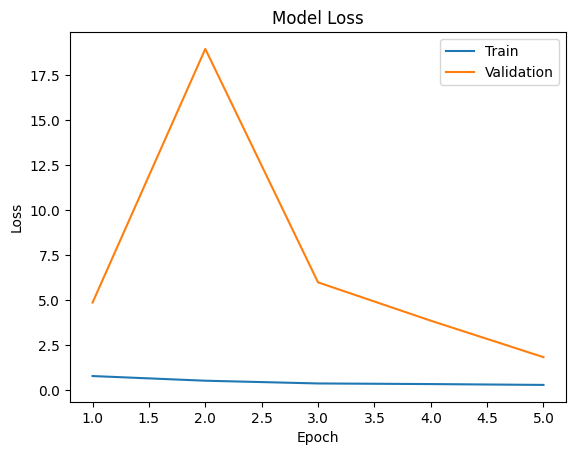

In [ ]:
plotLearningCurve(history,5)

# Apply model to predict input poster genre

In [ ]:
ind = 4
sample_id = raw_genre_img_df["imdb_id"][ind]
img = image.load_img(f'../raw_data/posters/drama/{sample_id}.jpg',target_size=(width,height,3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1,width,height,3)
classes = raw_genre_img_df.columns[5:]
y_pred = model.predict(img)
top3=np.argsort(y_pred[0])[:-4:-1]

print("The model predicts: ")
for i in range(3):
    print(classes[top3[i]])

print("Actual Genre: ")
print(raw_genre_img_df["genre"][ind])

KeyError: 4